# MLP for the Proposal Video

## Improvement Ideas
 - Penalize false positives more heavily using the Loss
 - Create bigger Dataset
 - Include the algorithms introduced in the Paper
 - Possibly change to CNN

## Current Problems
 - To many ill as healthy classified, especcialy early blight
 - To confident in wrong predictions



## 1. Import the required libraries

In [27]:
import os
import time
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib import transforms as mtransforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from sklearn.metrics import confusion_matrix

import kagglehub

## 2. Set model parameters

In [28]:
# Define the batch size (16 or 32 reccomended)
batch_size = 16

# Define the size the images get resized to (64 reccomended)
image_size = 64

# Number of epochs the trainig runs (150 reccomended)
number_of_epochs = 200

# Number of epochs without improvement of loss till the training get terminated early (20 reccomended)
early_stop_patience = 20

# If the dataset should be taken from the zip file (false reccomended (then the dataset gets downloaded))
dataset_as_zip = False

# Path of the zip file (only needed if dataset_as_zip = True)
zip_path = "../data/potato_blight.zip"

# Path where the best model should be saved to
best_model_path = '../content/best_model/best_model.pth'
if not os.path.exists(os.path.dirname(best_model_path)):
    os.makedirs(os.path.dirname(best_model_path))


## 3. Get the dataset

### 3.1 Import the dataset

In [29]:
if not dataset_as_zip:

    path = kagglehub.dataset_download("muhammadardiputra/potato-leaf-disease-dataset")

else:

    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"The data expected at '{zip_path}' was not found.")

    path = "../.extracted_data"

    if not os.path.exists(path):
        os.makedirs(path)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(path)

train_data_path = os.path.join(path + "/Potato", "Train")
test_data_path = os.path.join(path + "/Potato", "Test")
valid_data_path = os.path.join(path + "/Potato", "Valid")

### 3.2 Transform and argument the dataset

In [30]:
train_transform = transforms.Compose([
    transforms.RandomApply([transforms.Grayscale(num_output_channels=3)], p=0.5),
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=train_data_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root=valid_data_path, transform=val_transform)

### 3.3 Load the data into batches

In [31]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

for batch_idx, (data, target) in enumerate(train_loader):
    print(f'Batch {batch_idx + 1}:')
    print('Data shape:', data.shape)
    print('Target shape:', target.shape)

mean_image = torch.mean(torch.cat([data for data, _ in train_loader], dim=0), dim=0).numpy()

print('Mean image shape:', mean_image.shape)

Batch 1:
Data shape: torch.Size([16, 3, 64, 64])
Target shape: torch.Size([16])
Batch 2:
Data shape: torch.Size([16, 3, 64, 64])
Target shape: torch.Size([16])
Batch 3:
Data shape: torch.Size([16, 3, 64, 64])
Target shape: torch.Size([16])
Batch 4:
Data shape: torch.Size([16, 3, 64, 64])
Target shape: torch.Size([16])
Batch 5:
Data shape: torch.Size([16, 3, 64, 64])
Target shape: torch.Size([16])
Batch 6:
Data shape: torch.Size([16, 3, 64, 64])
Target shape: torch.Size([16])
Batch 7:
Data shape: torch.Size([16, 3, 64, 64])
Target shape: torch.Size([16])
Batch 8:
Data shape: torch.Size([16, 3, 64, 64])
Target shape: torch.Size([16])
Batch 9:
Data shape: torch.Size([16, 3, 64, 64])
Target shape: torch.Size([16])
Batch 10:
Data shape: torch.Size([16, 3, 64, 64])
Target shape: torch.Size([16])
Batch 11:
Data shape: torch.Size([16, 3, 64, 64])
Target shape: torch.Size([16])
Batch 12:
Data shape: torch.Size([16, 3, 64, 64])
Target shape: torch.Size([16])
Batch 13:
Data shape: torch.Size([16,

## 4. Define the model

In [32]:
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(3 * image_size * image_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 3)

        self.dropout = nn.Dropout(0.6)

    def forward(self, x):

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = F.relu(self.fc3(x))

        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

# create a CNN object
net = MLP()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
net.to(device)

num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

summary(net, (3, image_size, image_size))

Device: cuda:0
Number of trainable parameters: 3187331
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]       3,145,984
           Dropout-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
           Dropout-4                  [-1, 128]               0
            Linear-5                   [-1, 64]           8,256
            Linear-6                    [-1, 3]             195
Total params: 3,187,331
Trainable params: 3,187,331
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.01
Params size (MB): 12.16
Estimated Total Size (MB): 12.21
----------------------------------------------------------------


## 5. Train the model


### 5.1 Define and run the training

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.5,
                                                 patience=5,
                                                 min_lr=1e-6)

early_stop_counter = 0
best_val_loss = float('inf')
best_val_acc = 0.0
best_model_state = None

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(number_of_epochs):
    start_time = time.time()

    net.train()
    running_loss = 0.0
    correct = 0
    count = 0

    for batch, labels in train_loader:
        batch, labels = batch.to(device), labels.to(device)
        count += len(batch)

        optimizer.zero_grad()

        outputs = net(batch)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=2.0)

        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    avg_train_loss = running_loss / count
    avg_train_acc = correct / count
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(avg_train_acc)

    net.eval()
    val_loss = 0.0
    correct_val = 0
    count_val = 0

    with torch.no_grad():
        for batch, labels in val_loader:
            batch, labels = batch.to(device), labels.to(device)
            count_val += len(batch)

            outputs = net(batch)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            val_loss += loss.item()

    avg_val_loss = val_loss / count_val
    avg_val_acc = correct_val / count_val
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(avg_val_acc)

    elapsed_time = time.time() - start_time
    print(f"[Epoch {epoch+1}] Train loss: {avg_train_loss:.5f}, Train accuracy: {avg_train_acc:.4f}, "
          f"Val loss: {avg_val_loss:.5f}, Val accuracy: {avg_val_acc:.4f}, Time: {elapsed_time:.2f}s")

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_val_acc = avg_val_acc
        early_stop_counter = 0
        best_model_state = {
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
        }
        print(f"Saved best model at epoch {epoch+1} with validation loss: {best_val_loss:.5f}")
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch+1}. No improvement in validation loss for {early_stop_patience} epochs.")
            break

torch.save(best_model_state, best_model_path)
print(f"Best model saved with validation loss: {best_val_loss:.5f}, accuracy: {best_val_acc:.4f}")
net.load_state_dict(best_model_state['model_state_dict'])
optimizer.load_state_dict(best_model_state['optimizer_state_dict'])
net.to(device)

[Epoch 1] Train loss: 0.05908, Train accuracy: 0.5933, Val loss: 0.03755, Val accuracy: 0.7633, Time: 2.00s
Saved best model at epoch 1 with validation loss: 0.03755
[Epoch 2] Train loss: 0.04986, Train accuracy: 0.6444, Val loss: 0.03762, Val accuracy: 0.7800, Time: 2.05s
[Epoch 3] Train loss: 0.04568, Train accuracy: 0.7056, Val loss: 0.03598, Val accuracy: 0.7900, Time: 3.01s
Saved best model at epoch 3 with validation loss: 0.03598
[Epoch 4] Train loss: 0.04478, Train accuracy: 0.7178, Val loss: 0.03343, Val accuracy: 0.7733, Time: 4.07s
Saved best model at epoch 4 with validation loss: 0.03343
[Epoch 5] Train loss: 0.04227, Train accuracy: 0.7378, Val loss: 0.03121, Val accuracy: 0.8033, Time: 2.08s
Saved best model at epoch 5 with validation loss: 0.03121
[Epoch 6] Train loss: 0.04243, Train accuracy: 0.7289, Val loss: 0.03146, Val accuracy: 0.7867, Time: 2.01s
[Epoch 7] Train loss: 0.04100, Train accuracy: 0.7733, Val loss: 0.03047, Val accuracy: 0.8000, Time: 2.14s
Saved best m

MLP(
  (fc1): Linear(in_features=12288, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.6, inplace=False)
)

### 5.2 Train/Validation accuracy and loss

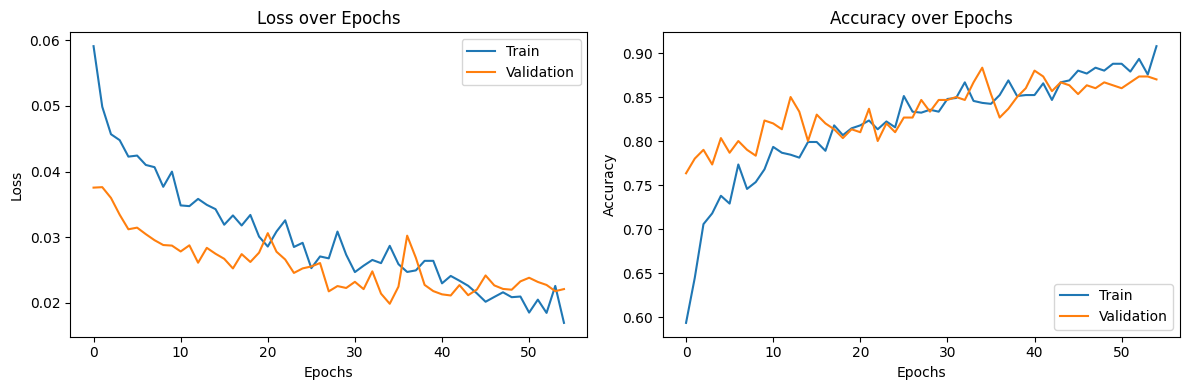

In [34]:
legend = ['Train', 'Validation']

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label=legend[0])
plt.plot(history['val_loss'], label=legend[1])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label=legend[0])
plt.plot(history['val_acc'], label=legend[1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy over Epochs')

plt.tight_layout()
plt.show()

## 6. Evaluate the model

### 6.1 Classify testdata using model

In [35]:
test_dataset = datasets.ImageFolder(root=test_data_path, transform=val_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

net.eval()

all_preds = []
all_labels = []
all_images = []
all_probs = []
class_labels = ['Late Blight', 'Early Blight', 'Healthy']

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_images.extend(images.cpu())
        all_probs.extend(probabilities.cpu().numpy())

correct_classifications = sum(np.array(all_preds) == np.array(all_labels))
incorrect_classifications = len(all_labels) - correct_classifications

print(f'Correctly classified: {correct_classifications}')
print(f'Incorrectly classified: {incorrect_classifications}')

Correctly classified: 266
Incorrectly classified: 34


### 6.2 Show confusion matrix of results

Explanation of the highlighted cells:
- Red rectangles: These cells represent cases where the illness is mistakenly classified as healthy. These cells have to be zero.
- Yellow rectangle: This cell represents cases where the severity of the illness is underestimated.
- Green rectangles: These are correct classifications.
- Other cells: These represent overestimated illness severity, which is less critical than underestimating.



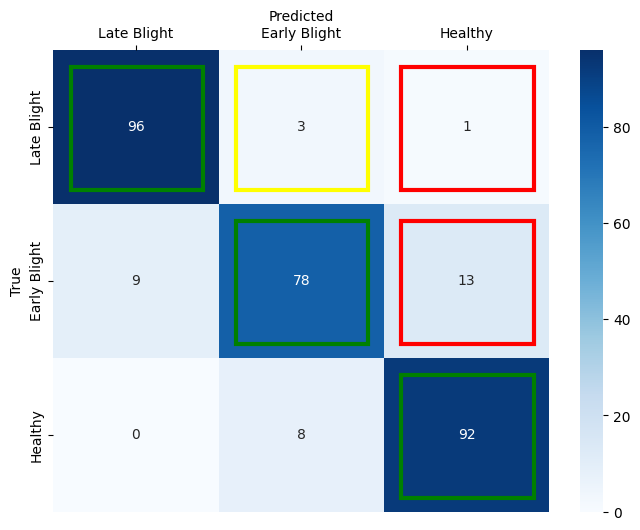

In [36]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
highlight_cells = [(0, 2), (0, 1), (1, 2), (0, 0), (1, 1), (2, 2)]

for (i, j) in highlight_cells:
    trans = mtransforms.offset_copy(ax.transData, fig=ax.figure, x=+12.5, y=-12.5, units='points')
    if (i, j) == (0, 1):
        color = 'yellow'
    elif (i, j) in [(0, 2), (1, 2)]:
        color = 'red'
    else:
        color = 'green'

    ax.add_patch(Rectangle((j, i), 0.8, 0.8, fill=False, edgecolor=color, lw=3, transform=trans))

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### 6.3 Define helper functions




In [37]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.clip(img, 0, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

def plot_probabilities(probs, class_labels, true_label_index, pred_label_index):
    bar_positions = np.arange(len(class_labels))  # X positions for bars
    probs_true = np.zeros_like(probs)
    probs_true[true_label_index] = 1  # Set true label to 1 for green bar

    plt.bar(bar_positions - 0.15, probs, width=0.3, color='blue', label='Predicted')

    plt.bar(bar_positions + 0.15, probs_true, width=0.3, color='green', label='True')

    plt.xticks(bar_positions, class_labels, fontsize=9)

    for i, (x, prob) in enumerate(zip(bar_positions, probs)):
        plt.text(x - 0.15, prob + 0.02, f'{prob:.2f}', ha='center', fontsize=6)

    plt.text(bar_positions[true_label_index] + 0.15, 1.02, '1.00', ha='center', fontsize=6)

    plt.ylim(0, 1.1)
    plt.ylabel('Probability')
    plt.tight_layout()

### 6.4 Show 9 correctly classified examples

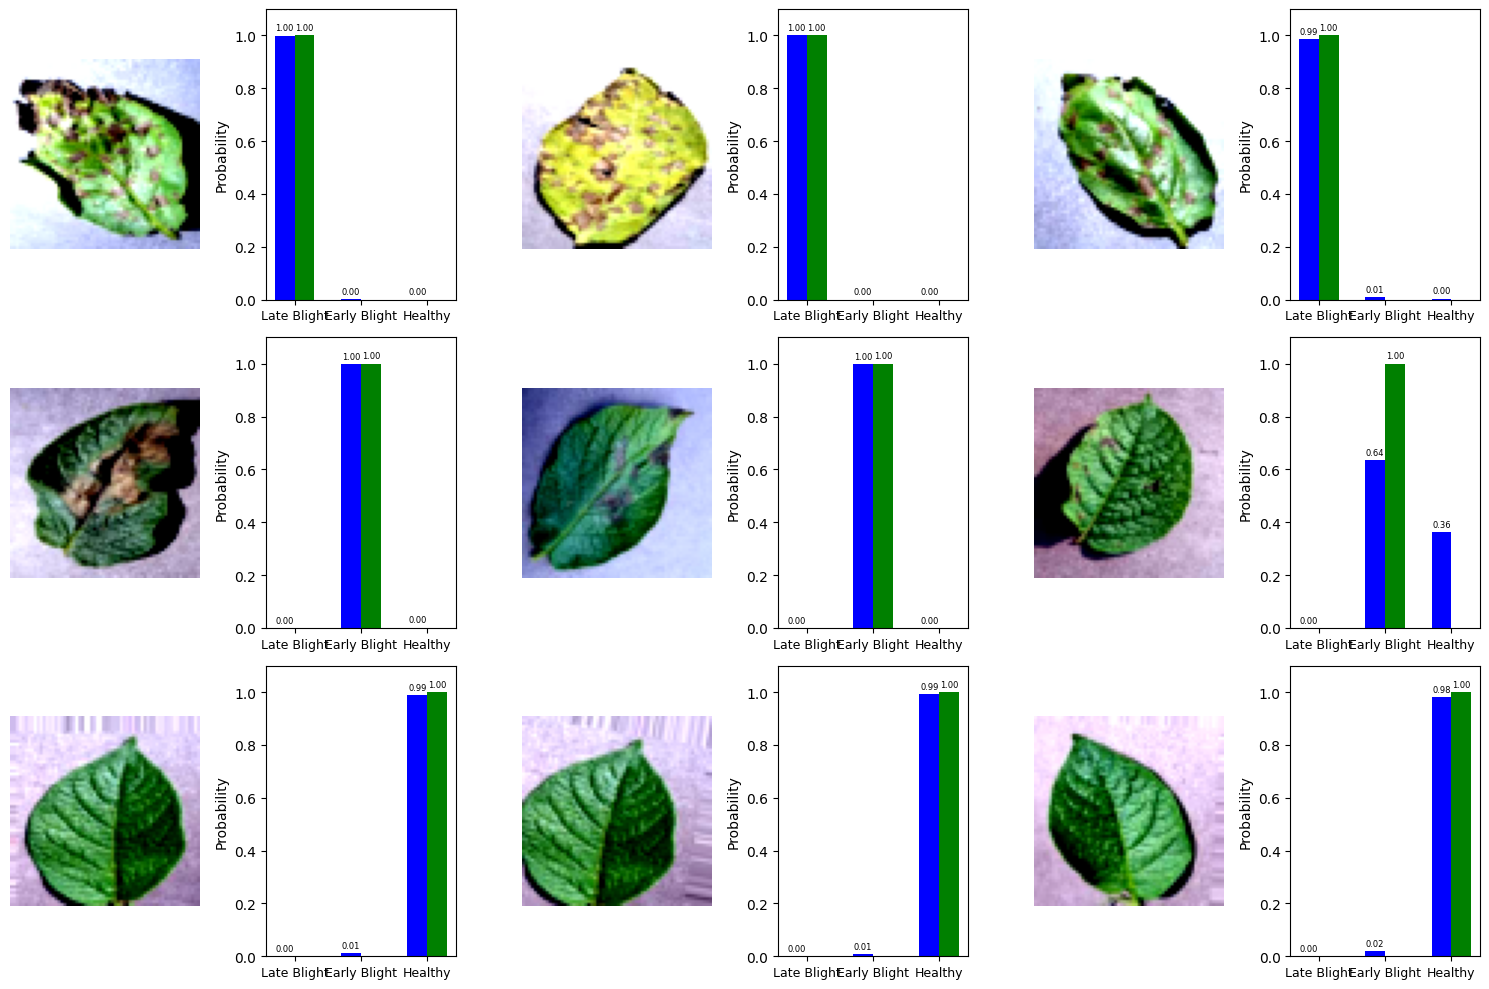

In [38]:
plt.figure(figsize=(15, 10))
num_samples_per_class = 3
samples_collected = {class_name: 0 for class_name in class_labels}

for i, (img, true_label, pred_label, prob) in enumerate(zip(all_images, all_labels, all_preds, all_probs)):
    true_class_name = class_labels[true_label]
    pred_class_name = class_labels[pred_label]

    if true_label == pred_label and samples_collected[true_class_name] < num_samples_per_class:
        samples_collected[true_class_name] += 1
        plt.subplot(len(class_labels), num_samples_per_class * 2, samples_collected[true_class_name] * 2 - 1 + num_samples_per_class * 2 * true_label)
        imshow(img)
        plt.subplot(len(class_labels), num_samples_per_class * 2, samples_collected[true_class_name] * 2 + num_samples_per_class * 2 * true_label)
        plot_probabilities(prob, class_labels, true_label, pred_label)

plt.tight_layout()
plt.show()

### 6.4 Show all misclassified images

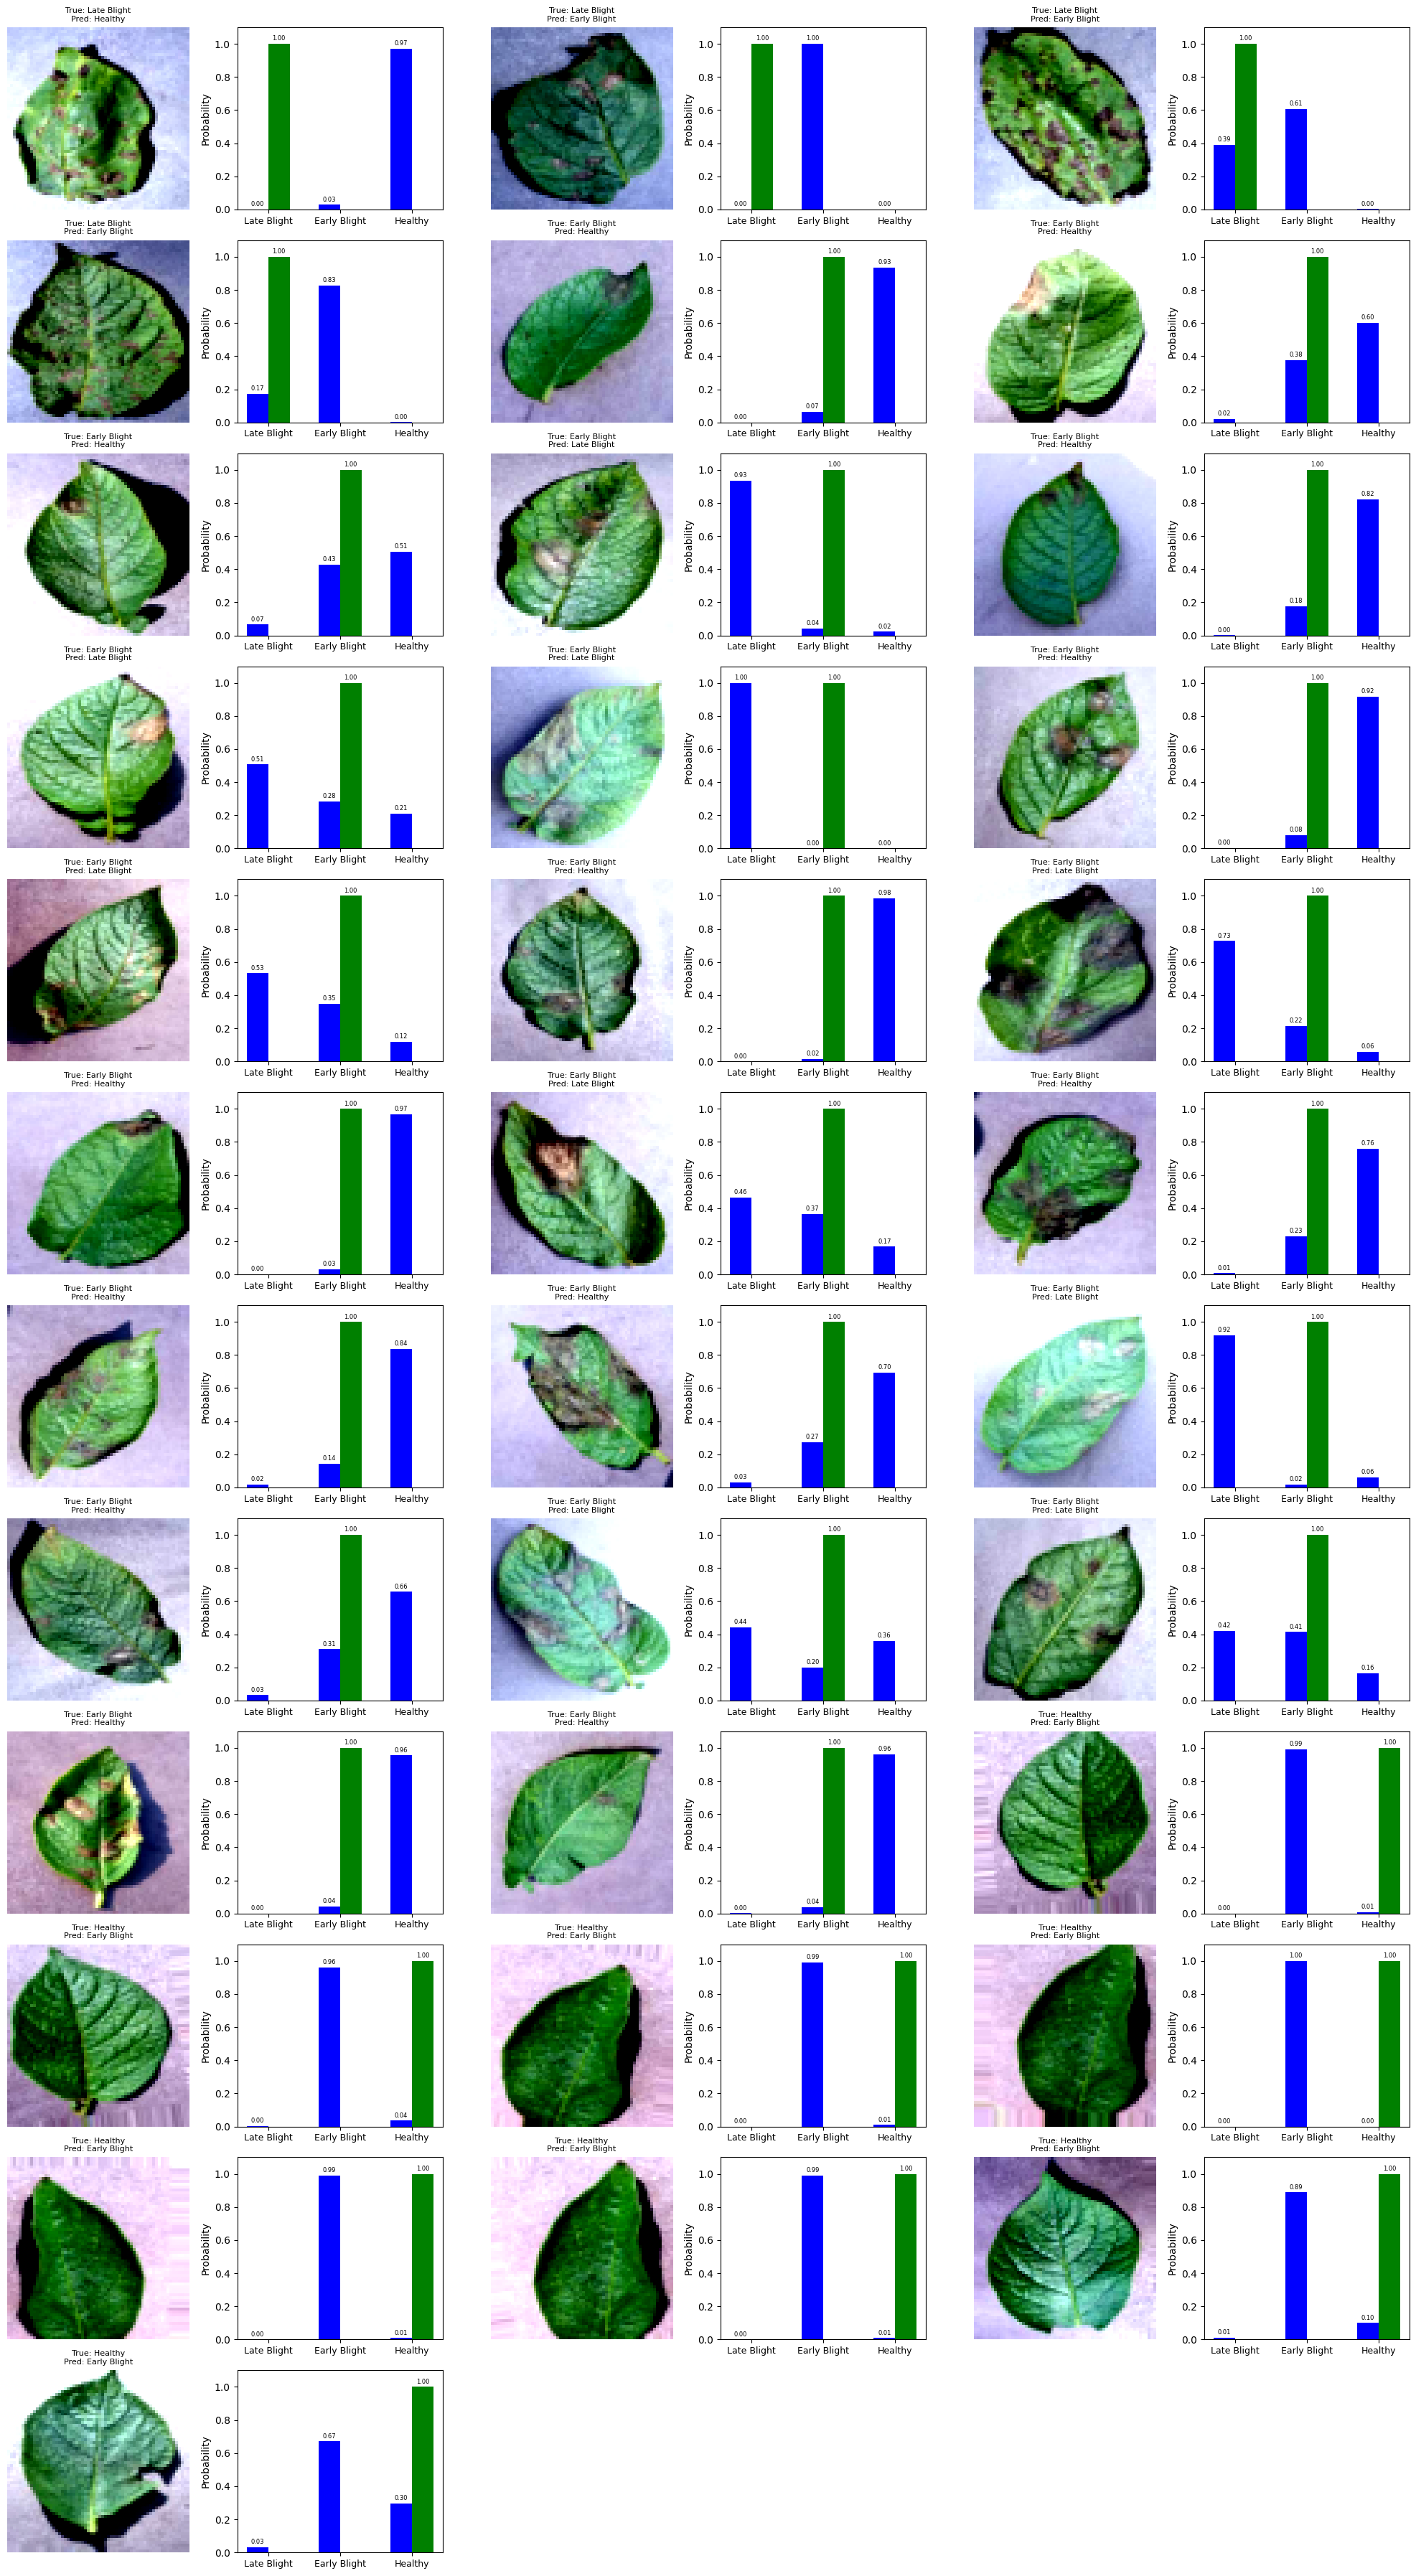

In [39]:
misclassified_images = [(img, true_label, pred_label, prob) for img, true_label, pred_label, prob in zip(all_images, all_labels, all_preds, all_probs) if true_label != pred_label]
num_misclassified = len(misclassified_images)

max_misclassified = 99
num_rows = min(33, (num_misclassified + 2) // 3)

plt.figure(figsize=(20, 3 * num_rows))

for i, (img, true_label, pred_label, prob) in enumerate(misclassified_images[:max_misclassified]):
    plt.subplot(num_rows, 6, i * 2 + 1)
    imshow(img)
    plt.title(f'True: {class_labels[true_label]}\nPred: {class_labels[pred_label]}', fontsize=8)
    plt.subplot(num_rows, 6, i * 2 + 2)
    plot_probabilities(prob, class_labels, true_label, pred_label)

plt.tight_layout()
plt.show()